In [2]:
import numpy as np
import matplotlib.pyplot as plt
from stochastic.processes import FractionalBrownianMotion
from utils import *

# Training Notebook:

This notebook trains the model from scratch on a large number of simulated fractional Brownian motion trajectories. It starts by generating a large dataset, it converts data into the correct shape and it instantiates efficient pytorch dataset and dataloader objects. The training loop is then run and evaluated.

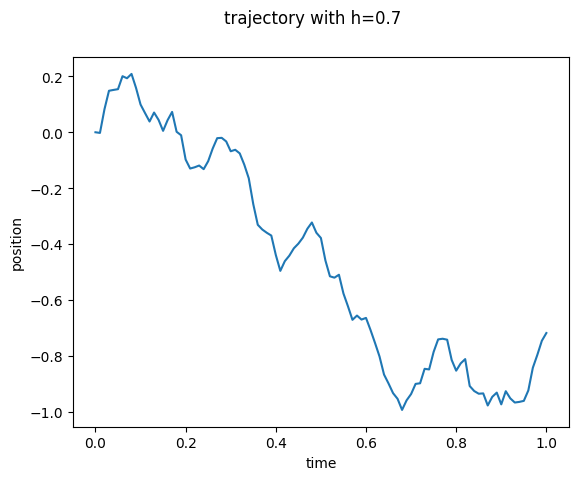

In [3]:
# Show a sample realization of a trajectory

alpha=1.4

f = FractionalBrownianMotion(hurst=0.5*alpha, t=1)
# Generate a fBm realization
fbm_sample = f.sample(100)
# Get the times associated with the fBm
t_values = f.times(100)
plt.plot(t_values[:10000], fbm_sample[:10000])
plt.xlabel('time')
plt.ylabel('position')
plt.suptitle("trajectory with h=0.7")
plt.show()

In [7]:
# Find the best device to train the model on
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")


Using cuda device


In [8]:
# Generate training and test datasets, convert them into pytorch friendly datasets and dataloader objects, instantiate the model, the loss function and the optimizer.

N_SIMS=60000 # Number of simulations
trajectory_length=100 # Number of steps to be sampled in each trajectory
batch_size=10 # Number of samples to be used in each iteration during the training loop
learning_rate=1e-3


X_train, Y_train, X_test, Y_test = generate_dataset(N_SIMS, trajectory_length)

train_data=SimulationDatset(X_train, Y_train)
train_loader=DataLoader(train_data, batch_size=batch_size)

test_data=SimulationDatset(X_test, Y_test)
test_loader=DataLoader(test_data, batch_size=batch_size)


model=DeepBrownianEncoder(embedding_dim=30, num_layers=1, num_heads=2).to(device)
loss_fn=nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Simulations Generated: 0
Simulations Generated: 10000
Simulations Generated: 20000
Simulations Generated: 30000
Simulations Generated: 40000
Simulations Generated: 50000


In [9]:
# Run the training loop.

epochs = 3
losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    loss = train(train_loader, model, loss_fn, optimizer, device)
    losses += (loss)
    DatasetMAE(test_loader, model, device)
print("Done!")

Epoch 1
-------------------------------
loss: 1.400319  [   10/42000]
loss: 0.112717  [ 1010/42000]
loss: 0.155853  [ 2010/42000]
loss: 0.107309  [ 3010/42000]
loss: 0.083263  [ 4010/42000]
loss: 0.074561  [ 5010/42000]
loss: 0.119022  [ 6010/42000]
loss: 0.055052  [ 7010/42000]
loss: 0.126076  [ 8010/42000]
loss: 0.054676  [ 9010/42000]
loss: 0.094706  [10010/42000]
loss: 0.100064  [11010/42000]
loss: 0.048195  [12010/42000]
loss: 0.064567  [13010/42000]
loss: 0.087134  [14010/42000]
loss: 0.058366  [15010/42000]
loss: 0.075674  [16010/42000]
loss: 0.082770  [17010/42000]
loss: 0.071083  [18010/42000]
loss: 0.059627  [19010/42000]
loss: 0.061295  [20010/42000]
loss: 0.046087  [21010/42000]
loss: 0.098377  [22010/42000]
loss: 0.060357  [23010/42000]
loss: 0.029487  [24010/42000]
loss: 0.083392  [25010/42000]
loss: 0.042715  [26010/42000]
loss: 0.057603  [27010/42000]
loss: 0.030084  [28010/42000]
loss: 0.074308  [29010/42000]
loss: 0.072761  [30010/42000]
loss: 0.055526  [31010/42000]


[]

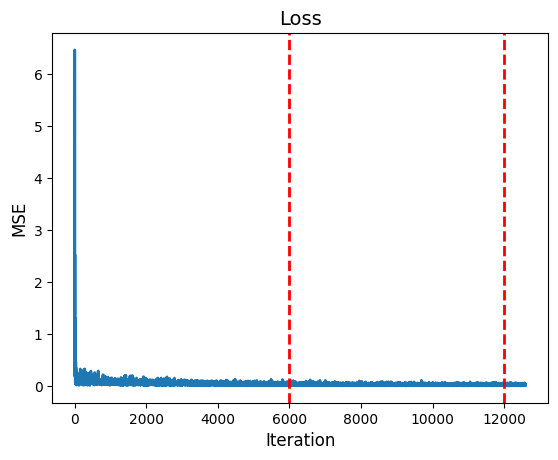

In [11]:
# Show the loss value as a function of the number of iterations in the training loop. Red dashed lines represent epochs.

plt.plot(losses, linewidth=2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Loss', fontsize=14)
for e in range(1, epochs):
    plt.axvline(x=e*(N_SIMS/batch_size), color='red', linewidth=2, label='epoch', linestyle='--')
#plt.legend(fontsize=12)
plt.plot()

In [6]:
#Save model
torch.save(model.state_dict(), 'model/model_weights.pth')